# **3D PART SEGMENTATION USING PointNet**

This Notebook is based on the [PointNet](https://arxiv.org/abs/1612.00593) architecture proposed by Charles R. Qi, Hao Su, Kaichun Mo, Leonidas J. Guibas.

The original code in tensorflow can be found [here](https://github.com/charlesq34/pointnet).

#GPU for training

To choose the GPU for training, select Runtime > Change runtime type choose hardware accelerator (change None to GPU).

# Import the necessary dependencies

In [ ]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Reshape
from keras.layers import Conv1D, BatchNormalization, Dropout, GlobalMaxPooling1D
from keras.layers import Lambda, concatenate
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# For cool 3D interactive visualisations
import plotly.graph_objs as go
import plotly.express as px

# Input the data (and lets examine it). 


In [ ]:
!pip install gdown

!gdown https://drive.google.com/uc?id=1JrSRzbZ7kC5Xxoq_7nefynD28HFqMaMQ
!unzip data.zip -d /content

Downloading...
From: https://drive.google.com/uc?id=1JrSRzbZ7kC5Xxoq_7nefynD28HFqMaMQ
To: /content/data.zip
320MB [00:05, 63.1MB/s]
Archive:  data.zip
  inflating: /content/data_seg/train_data.npy  
  inflating: /content/data_seg/train_labels.npy  
  inflating: /content/data_seg/val_data.npy  
  inflating: /content/data_seg/val_label.npy  


In [ ]:
train_points = np.load('/content/data_seg/train_data.npy')
train_labels = np.load('/content/data_seg/train_labels.npy')

valid_points = np.load('/content/data_seg/val_data.npy')
valid_labels = np.load('/content/data_seg/val_label.npy')

Let's examine the data. 

In [ ]:
print("Training shape: ", train_points.shape)
print("Test shape: \t", valid_points.shape)

Training shape:  (12137, 2048, 3)
Test shape: 	 (1870, 2048, 3)


The data is of shape: ( _n_ x number of points x coordinates (x,y,z) ). Here, we can see that we have 12137 samples in our training set and 1870 in our test with each sample (3D object) has 2048 points represented by an x,y,z coordinates.


Now let's plot some examples !

In [ ]:
def plot_ply(file):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)
    x = file[:, 0]
    y = file[:, 1]
    z = file[:, 2]
    ax.scatter(x, y, z, marker='.', zdir='z')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

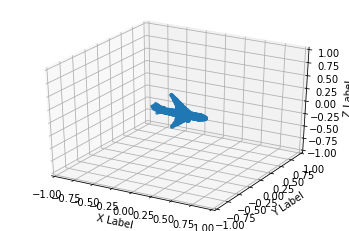

In [ ]:
# extract 1 image from dataset
first_object = train_points[192]
# plot point cloud 
plot_ply(first_object)

Ok... so it looks like a.... I am not sure what it looks like, so lets look at it using an interactive 3D tool. 

In [ ]:
# Define X,Y,Z vectors
X=first_object[:,0]
Y=first_object[:,1]
Z=first_object[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=10, color=Z, colorscale='Viridis', opacity=0.4))

data = [trace1]
layout = go.Layout(height=500, width=600)
fig = go.Figure(data=data, layout=layout)
fig.show()


well, it's a lamp :) 

# Lets build the model

### Input and Feature transform network : Tnet

The first transformation that occurs is called the input transformation (T-Net 1). This aligns the input point cloud as it can have arbitrary orientations. This is also known as an 'afine transformation'.
![](https://drive.google.com/uc?id=14WD-6abIL4RwuLZRGgFPzN8LgNszlU1k)

Input transformation network (T-Net1) is for predicting a transformation matrix to map a point cloud to canonical space before processing. A similar network is used to transform the features, the only difference is that the output corresponds to a 64x64 matrix (T-Net2).

The first transformation network is a mini-PointNet that takes raw point cloud as input and regresses to a 3 × 3 matrix. It’s composed of a shared MLP (64, 128, 1024) network, a max pooling across points and two fully connected layers with output sizes 512, 256. The output matrix is initialized as an identity matrix. All layers, except the last one, include ReLU and batch normalization. 

The second T-Net block is with the same idea, but this time for aligning in the embedding space. The embedding space essentially projects the features into a higher dimensional space so that the features are more alike and have a small distance between them in the embedded space.
The architecture is also different: bigger number of neurons and the output is a 64 × 64 matrix. 

In [ ]:
def TNet(inputs, tsize, mlp_nodes=(64, 128, 1024), fc_nodes=(512, 256)):

    x = inputs
    for i, num_nodes in enumerate(mlp_nodes):
        x = Conv1D(filters=num_nodes, kernel_size=1, padding='VALID', strides=1, 
                   activation='relu')(x)
        x = BatchNormalization(momentum=0.99)(x)

    x = GlobalMaxPooling1D()(x)

    for i, num_nodes in enumerate(fc_nodes):
        x = Dense(num_nodes, activation='relu', use_bias=True, bias_initializer=keras.initializers.Zeros())(x)
        x = BatchNormalization(momentum=0.99)(x)

    x = Dense(tsize * tsize,
              weights=[np.zeros([num_nodes, tsize * tsize]), np.eye(tsize).flatten().astype(np.float32)])(x) 
    transformation_matrix = Reshape((tsize, tsize))(x)
    return transformation_matrix


### Features extraction : MLP

In [ ]:
def multilayer_perceptron(inputs, mlp_nodes):
    '''
    Define multilayer-perceptron
    '''
    mlp = []
    x = inputs

    for i, num_nodes in enumerate(mlp_nodes):
        x = Conv1D(filters=num_nodes, kernel_size=1, padding='VALID', strides=1, 
                   activation='relu')(x)
        x = BatchNormalization(momentum=0.99)(x)
        #x = Dropout(0.2)(x)
        mlp.append(x)
    return mlp

### Put it all together

In [ ]:
def extend_dimension(global_feature, axis):
    '''
    Extend dimension of a tensor(example: [None, 1024] to [None, 1, 1024])
    '''
    return tf.expand_dims(global_feature, axis)


def extend_size(global_feature, num_points):
    '''
    Extend size of a tensor(example: [None, 1, 1024] to [None, num_points, 1024])
    '''
    return tf.tile(global_feature, [1, num_points, 1])



def PointNetFull(num_points, num_classes):
    '''
    Pointnet full architecture
    :param num_points: an integer that is the number of input points
    :param num_classes: an integer that is number of categories
    '''

    inputs = Input(shape=(num_points, 3))

    tnet1 = TNet(inputs=inputs, tsize=3, mlp_nodes=(64, 128, 1024), fc_nodes=(512, 256))

    aligned_feature1 = keras.layers.dot(inputs=[inputs, tnet1], axes=2)

    extracted_feature11, extracted_feature12, extracted_feature13 = multilayer_perceptron(inputs=aligned_feature1,
                                                                                          mlp_nodes=(64, 128, 128))

    tnet2 = TNet(inputs=extracted_feature13, tsize=128, mlp_nodes=(256, 1024), fc_nodes=(512, 256))

    aligned_feature2 = keras.layers.dot(inputs=[extracted_feature13, tnet2], axes=2)


    extracted_feature21, extracted_feature22 = multilayer_perceptron(inputs=aligned_feature2, mlp_nodes=(512, 2048))

    global_feature = GlobalMaxPooling1D()(extracted_feature22)

    global_feature_seg = Lambda(extend_dimension, arguments={'axis': 1})(global_feature)

    global_feature_seg = Lambda(extend_size, arguments={'num_points': num_points})(global_feature_seg)


    # Segmentation block
    seg = concatenate(
        [extracted_feature11, extracted_feature12, extracted_feature13, aligned_feature2, extracted_feature21,
         global_feature_seg])

    seg1, seg2, seg3 = multilayer_perceptron(inputs=seg, mlp_nodes=(256, 256, 128))

    segmentation_result = Conv1D(num_classes, 1, padding='VALID', activation='softmax', bias_regularizer=keras.regularizers.l2(0.001))(seg3)

    model = Model(inputs=inputs, outputs=segmentation_result)

    return model



# Train !

First, let's define some data augmentation methods.

In [ ]:
def rotate_point_cloud(batch_data):
    '''
    Randomly rotate the point cloud to augment the dataset, rotation is per
    shape based along up direction
    Input : B x N x 3 array, original batch of point clouds
    Returns : B x N x 3 array, rotated batch of point clouds
    '''

    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    '''
    Randomly jitter points, jittering is per point. 
    Input : B x N x 3 array, original batch of point clouds
    Returns : B x N x 3 array, jittered batch of point clouds
    '''
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data


Define model parameters

In [ ]:
batch_size = 32
num_epoches = 10
# number of categories
num_classes = 51 #(from 1 to 51)
# number of points per point cloud
num_points = 2048
# learning rate
lr = 0.001
# Optimizer
opt = keras.optimizers.Adam(learning_rate= lr)
#opt = keras.optimizers.SGD(learning_rate= lr)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


One hot encode the labels

In [ ]:
one_hot_train_labels = np_utils.to_categorical(train_labels, num_classes)
one_hot_valid_labels = np_utils.to_categorical(valid_labels, num_classes)

Compile

In [ ]:
model = PointNetFull(num_points=num_points, num_classes=num_classes)
#print(model.summary())
model.compile(optimizer=opt,
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

Define checkpoint

In [ ]:
checkpoint = ModelCheckpoint(
    filepath = "/content/data_seg/weights.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    # Save weights every 1 epochs.
    period=1
)

Define function to decay learning rate every 20 epochs

In [ ]:
def decay_schedule(epoch, lr):
    # decay LR every 20 epochs
    if (epoch % 20 == 0) and (epoch != 0):
        lr = lr / 2
    return lr
    
lr_scheduler = LearningRateScheduler(decay_schedule)


Train

In [ ]:
for epoch in range(num_epoches):

    # rotate and jitter point cloud in every epoch
    train_points_rotate = rotate_point_cloud(train_points)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    
    model.fit(train_points_jitter, one_hot_train_labels, 
              batch_size=batch_size, epochs=1,validation_split=0.2, 
              callbacks=[lr_scheduler, checkpoint], shuffle=True, verbose=1)
    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 9709 samples, validate on 2428 samples
Epoch 1/1
9709/9709 [==============================] - 116s 12ms/step - loss: 1.0715 - accuracy: 0.6786 - val_loss: 8.7419 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 8.74188, saving model to /content/data_seg/weights.h5
Train on 9709 samples, validate on 2428 samples
Epoch 1/1
9709/9709 [==============================] - 113s 12ms/step - loss: 0.6735 - accuracy: 0.7842 - val_loss: 1.3940 - val_accuracy: 0.6861

Epoch 00001: val_loss improved from 8.74188 to 1.39403, saving model to /content/data_seg/weights.h5
Train on 9709 samples, validate on 2428 samples
Epoch 1/1
9709/9709 [==============================] - 113s 12ms/step - loss: 0.5867 - accuracy: 0.8087 - val_loss: 0.3790 - val_accuracy: 0.8993

Epoch 00001: val_loss improved from 1.39403 to 0.37900, saving model to /content/data_seg/weights.h5
Train on 9709 sam

# Evaluate and visualize

Test performance


In [ ]:
model.load_weights('/content/data_seg/weights.h5')

In [ ]:
score = model.evaluate(valid_points,one_hot_valid_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

1870/1870 [==============================] - 7s 4ms/step
Test loss: 0.38717369775083615
Test accuracy: 0.8755007982254028


Select one test data to visualize


In [ ]:
v_points = valid_points[192:193,:,:]
pred = model.predict(v_points)
pred = np.squeeze(pred)
v_points = np.squeeze(v_points)
pred = pred.tolist()

index = []
for i in range(v_points.shape[0]):
    index.append(np.argmax(pred[i]))
index = set(index)
dict={}
for c, i in enumerate(index):
  dict[i] = c 


colors = ['b', 'g', 'g', 'r', 'y', 'b']
m= ['o', 'v', '<', '>', '^', 'v']
c = []
for i in range(v_points.shape[0]):
    xs = v_points[i,0]
    ys = v_points[i,1]
    zs = v_points[i,2]
    ind = dict[np.argmax(pred[i])]
    c.append(colors[ind])

fig = px.scatter_3d(v_points, x=v_points[:,0], y=v_points[:,1], z=v_points[:,2], color=c)
fig.show()
      